## Calling the Data Reader Class

In [ ]:
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)
d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)
print("WIDERFACE data is read!")

## Drawing a Ground Truth Image

In [ ]:
include("./BBTNet/utils/ImageReader.jl")

train_reader = Image_Reader(true) # true for augmentation, false for only square resize

file_name = "22--Picnic/22_Picnic_Picnic_22_231.jpg"
img, bboxes = read_img(train_reader, wf_path * "train/images/" * file_name, d.bboxes[file_name], 640)
img += avg_img
print("Image file is read: ", file_name, '\n')

In [ ]:
include("./BBTNet/utils/draw.jl")
draw_boxes_and_landmarks(img, bboxes)

## Drawing Image From Manual Data

In [ ]:
using Images

include("./BBTNet/utils/draw.jl")

d = reshape([449 330 571 479 488.906 373.643 542.089 376.442 515.031 412.83 485.174 425.893 538.357 431.491], (14, 1))
path = wf_path * "train/images/0--Parade/0_Parade_marchingband_1_849.jpg"

img = channelview(load(path))
draw_boxes_and_landmarks(img, d)

## Training the Model

In [80]:
include("BBTNet/models/retinaface.jl")
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)

batch_size = 2

d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=false, batch_size=batch_size, dtype=atype)

model = RetinaFace(dtype=atype)
print("Model is loaded!")

Model is loaded!

In [ ]:
include("BBTNet/models/retinaface.jl")
train_model(model, d, save_dir=save_dir)


--- Epoch: 1 & Batch: 0/2

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

Excessive output truncated after 524288 bytes.

[97378] --> Float32[0.10786949 0.89213055]
Boxes: --> [284.15944224063463 149.91277025256824 340.0304875042461 222.08159074587076]
Landmarks: --> [313.2058886742675 175.91803677835128 311.5559399405768 176.71772129139254 313.339719940583 191.52609617204303 312.8720277860908 202.02755780428402 311.64903101600976 201.91847367239302]
[INFO] Returning results above confidence level: 0.9955.
(0, 4)(0, 10)

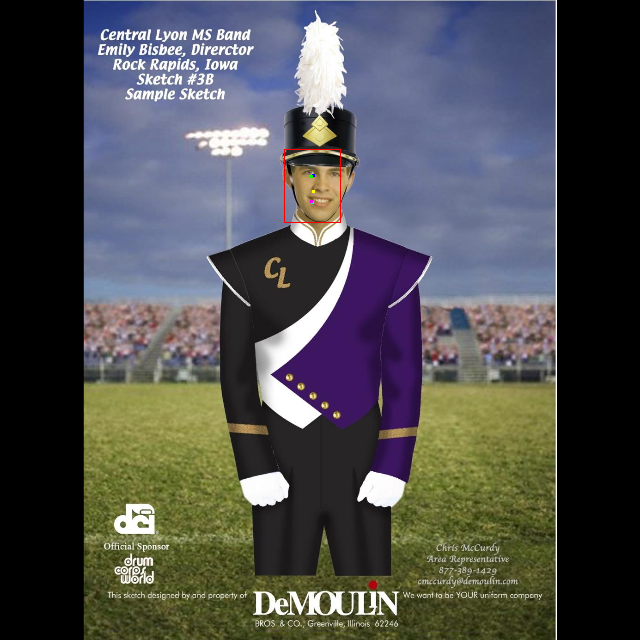

In [20]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

conf_level      = 0.9955
bs = 1

dataset_path = wf_path * "train/" 
labels_path = wf_labels_path * "train/"

d = WIDER_Data(dataset_path, labels_path, train=false, batch_size=bs, dtype=atype)
img_path = d.files[1]

img, boxes = read_img(d.reader, dataset_path * "images/" * img_path, d.bboxes[img_path], img_size)
imgs = convert(atype, permutedims(reshape(img, (3, img_size, img_size, 1)), (3,2,1,4))) .* 255



model = load_model(save_dir * "model_8.jld2")
c, b, l = predict_model(model, imgs; y=boxes, mode=1) 

# b[1] = [284.15944224063463 149.91277025256824 340.0304875042461 222.08159074587076]
# l[1] = [
#     313.2058886742675 175.91803677835128 
#     311.5559399405768 176.71772129139254 
#     313.339719940583 191.52609617204303 
#     312.8720277860908 202.02755780428402 
#     311.64903101600976 201.91847367239302]

combined_pts = permutedims(Array(cat(b[1], l[1], dims=2)), (2, 1))

img += avg_img
draw_boxes_and_landmarks(img, combined_pts)

## Testing the Model

#### Testing a Batch

In [ ]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

Random.seed!(42)

val_data = WIDER_Data(wf_path * "val/", wf_labels_path * "val/", train=false, batch_size=batch_size, dtype=atype)
(imgs, boxes), state = iterate(val_data)

# model = RetinaFace(dtype=atype)
model = load_model(save_dir * "model_1.jld2")
c, b, l = model(imgs, nothing, mode, false, 0)

for b in 1:batch_size
    print("For Batch Image: ", b, " found ", size(c[b],1), " proposals!\n")
end

In [ ]:
# image conversion to actual shape and cpu type for the first image in the prediction
img_no = 10
img_cpu = Array(permutedims(imgs[:,:,:,img_no], (3,2,1))) ./ 255 + avg_img
combined_pts = permutedims(Array(cat(b[img_no], l[img_no], dims=2)), (2, 1))

draw_boxes_and_landmarks(img_cpu, combined_pts)

#### Testing an Individual Image

In [4]:
include("BBTNet/datasets/WIDERFACE.jl")
# include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

sample_paths = [
    "18--Concerts/18_Concerts_Concerts_18_537.jpg", 
    "2--Demonstration/2_Demonstration_Demonstrators_2_688.jpg", 
    "0--Parade/0_Parade_Parade_0_652.jpg", 
    "55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_327.jpg"
]

dataset_path = wf_path * "train/" 
labels_path = wf_labels_path * "train/"
img_path = sample_paths[2]
# img_path = "0--Parade/0_Parade_marchingband_1_849.jpg"

d = WIDER_Data(dataset_path, labels_path, train=false, batch_size=1, dtype=atype)
img, boxes = read_img(d.reader, dataset_path * "images/" * img_path, d.bboxes[img_path], img_size)
imgs = convert(atype, permutedims(reshape(img, (3, img_size, img_size, 1)), (3,2,1,4))) .* 255

model = load_model("./weights/model_7.jld2")
c, b, l = model(imgs, nothing, mode, false, 0)


boxes = permutedims(boxes, (2, 1))
gt, pos_indices, neg_indices = encode_gt_and_get_indices(boxes, 0.5, 0.4)
print("Probabilities of boxes: ", c[1][pos_indices,1], "\n")
b[1] = b[1][pos_indices, :]
l[1] = l[1][pos_indices, :]

combined_pts = permutedims(Array(cat(b[1], l[1], dims=2)), (2, 1))

img += avg_img
draw_boxes_and_landmarks(img, combined_pts)

[15.625 131.875 69.375 118.75 209.375 317.5 371.875 435.625 509.375 553.125 604.375 616.25 629.375 626.25 617.5 572.5 549.375 393.125 498.125 594.375; 446.875 381.875 451.875 435.625 460.0 499.375 465.0 468.75 430.0 446.875 446.25 455.625 310.625 274.375 294.375 300.0 333.125 275.625 390.625 305.625; 51.875 155.0 123.75 151.875 241.25 340.625 414.375 482.5 549.375 586.875 635.625 640.0 637.5 634.375 625.625 580.0 556.875 430.0 506.25 603.75; 518.125 417.5 521.875 511.875 511.25 553.125 526.25 537.5 478.125 498.125 490.625 513.125 323.75 283.75 302.5 313.125 341.875 334.375 402.5 320.0; 44.464375000000004 126.69624999999999 104.31375 -1.0 -1.0 -1.0 386.964375 -1.0 530.2875 559.0068749999999 623.2587500000001 622.6118749999999 -1.0 -1.0 -1.0 573.515625 -1.0 410.13687500000003 -1.0 -1.0; 480.535625 391.11625 476.735625 66.875 66.875 66.875 489.609375 66.875 445.85125 466.674375 476.328125 475.306875 66.875 66.875 66.875 305.091875 66.875 295.78125 66.875 66.875; 48.92875 133.169375 118.86

In [41]:
c[1][174, :]

2-element Array{Float32,1}:
 0.19173418
 0.80826586

## Saving & Loading the Model

In [ ]:
save_model(model, save_dir * "dummy_path.jld2")

In [ ]:
model = load_model(save_dir * "model_epoch1.jld2")
print("Model is loaded from a file!\n")

## Issues on Loading ResNet50 Weights

In [ ]:
include("./BBTNet/backbones/resnet.jl")
include("./BBTNet/utils/ImageReader.jl")
include("configs.jl")

img_path = "./data/cat_img.jpg"
img = convert(atype, read_img(Image_Reader(false), img_path, nothing, img_size))
img = permutedims(reshape(img, (1, 3, img_size, img_size)), (4, 3, 2, 1)) .* 255

rn = load_mat_weights(ResNet50(dtype=atype), "./weights/imagenet-resnet-50-dag.mat")
evaluate_model(rn, img)

In [ ]:
using Knet

In [13]:
N = 3; P = 90; C = 2; thold = 0.7;

cls = softmax(randn(N, P, C), dims=3)
labels = zeros(N,P)
pos_idx = findall(cls[:,:,1] .>= thold)
neg_idx = findall(cls[:,:,2] .>= thold)

labels[pos_idx] .= 1
labels[neg_idx] .= 2

print("Parameters are set!")

Parameters are set!

In [16]:
print(cls[1,2,:], " --> ", labels[1,2])

[0.7720156825945833, 0.22798431740541678] --> 1.0

In [18]:
cls_vals = reshape(permutedims(cls, (3, 2, 1)), (2, N*P))
batch_cls = vec(permutedims(labels, (2, 1)))

print("Conversion is made!")

Conversion is made!

In [35]:
print(cls_vals[:,10], " --> ", batch_cls[10])

[0.7749085506245315, 0.22509144937546863] --> 1.0

In [36]:
for n in 1:N*P
    if cls_vals[1,n] >= thold && batch_cls[n] != 1.0
        print("In n: ", n, " --> ", cls_vals[:,n], " || ", batch_cls[n], "\n")
    elseif cls_vals[2,n] >= thold && batch_cls[n] != 2.0
        print("In n: ", n, " --> ", cls_vals[:,n], " || ", batch_cls[n], "\n")
    elseif cls_vals[1,n] < thold && cls_vals[2,n] < thold && batch_cls[n] != 0.0
        print("In n: ", n, " --> ", cls_vals[:,n], " || ", batch_cls[n], "\n")
    end
end

[13719] --> Float32[0.9998491 0.00015091355]
Boxes: --> [222.56422233581543 144.3120150566101 270.16909980773926 234.35553312301636]
Landmarks: --> [70.6805419921875 178.4943528175354 231.34554290771484 167.16304206848145 143.23069763183594 299.3547897338867 115.48500061035156 323.9100646972656 268.12876892089844 330.06846618652344]
[INFO] Returning results above confidence level: 0.9.


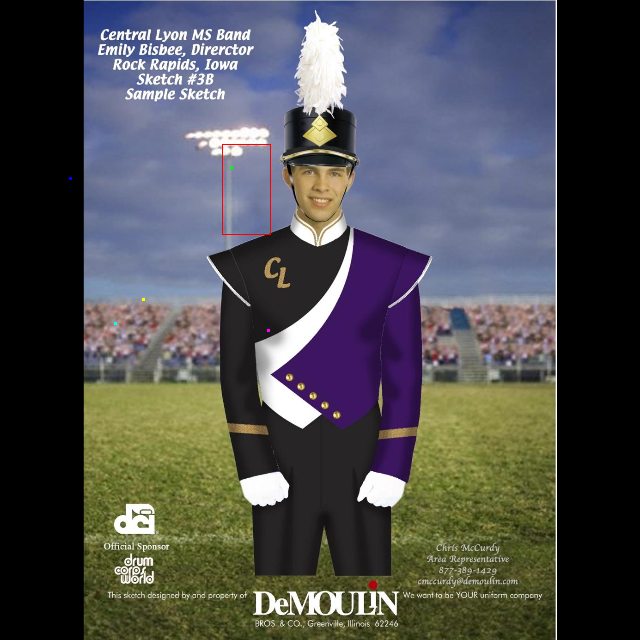

In [63]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("BBTNet/models/pth_load_retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

bs = 1

dataset_path = wf_path * "train/" 
labels_path = wf_labels_path * "train/"

d = WIDER_Data(dataset_path, labels_path, train=false, batch_size=bs, dtype=atype)
img_path = d.files[1]

img, boxes = read_img(d.reader, dataset_path * "images/" * img_path, d.bboxes[img_path], img_size)
imgs = convert(atype, permutedims(reshape(img, (3, img_size, img_size, 1)), (3,2,1,4))) .* 255

model = RetinaFace(dtype=atype)
model = load_pth_model(model, "./weights/Resnet50.jld"; dtype=atype)

c, b, l = predict_model(model, imgs; y=boxes, mode=mode) 

# b[1] = [222.56422233581543 144.3120150566101 270.16909980773926 234.35553312301636]
# l[1] = [70.6805419921875 178.4943528175354 231.34554290771484 167.16304206848145 143.23069763183594 299.3547897338867 115.48500061035156 323.9100646972656 268.12876892089844 330.06846618652344]

combined_pts = permutedims(Array(cat(b[1], l[1], dims=2)), (2, 1))

img .+= avg_img
draw_boxes_and_landmarks(img, combined_pts)

In [44]:
save_model(model, "./weights/PyTorch_RetinaFace_mode2_scales3.jld2")

In [45]:
img_path

"0--Parade/0_Parade_marchingband_1_849.jpg"

In [51]:
value(imgs[320, 320, :, 1])

3-element KnetArray{Float32,1}:
 131.0
 143.0
 155.0

In [64]:
value(imgs[320, 320, :, 1])

3-element KnetArray{Float32,1}:
 151.0
 138.0
 132.0